In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
from scipy import fftpack
import seaborn as sns
style.use('seaborn')

In [2]:
def rename_column(df,prefix):
    column_name = list(df.columns)
    column_name = [prefix + name for name in column_name]
    return df.set_axis(column_name, axis=1)

In [3]:
target_set = pd.read_csv(".\\bearing_classes.csv",sep=";")
origin_set = pd.read_csv(".\\bearing_signals.csv")

In [54]:
df_train = origin_set.drop(['experiment_id','bearing_1_id', 'timestamp'],axis=1)

In [55]:
df_bearing_1_x = df_train.drop(['a2_x','a2_y','a2_z','a1_y','a1_z'], axis = 1)
df_bearing_1_y = df_train.drop(['a2_x','a2_y','a2_z','a1_x','a1_z'], axis = 1)
df_bearing_1_z = df_train.drop(['a2_x','a2_y','a2_z','a1_x','a1_y'], axis = 1)
df_bearing_2_x = df_train.drop(['a1_x','a1_y','a1_z','a2_y','a2_z'], axis = 1)
df_bearing_2_y = df_train.drop(['a1_x','a1_y','a1_z','a2_x','a2_z'], axis = 1)
df_bearing_2_z = df_train.drop(['a1_x','a1_y','a1_z','a2_x','a2_y'], axis = 1)
bearing_feature = [df_bearing_1_x,df_bearing_1_y,df_bearing_1_z,df_bearing_2_x,df_bearing_2_y,df_bearing_2_z]
list_column = ['fft_a1_x','fft_a1_y','fft_a1_z','fft_a2_x','fft_a2_y','fft_a2_z']

In [56]:
def by_axis_bearing(bearing_feature,i):
    max_list = []
    for index in range(len(bearing_feature)):
        bearing_idx = bearing_feature[index]
        df_bearing = bearing_idx[bearing_idx['bearing_2_id'] == i]
        fft_values = fftpack.fft(df_bearing)
        max_amplitude = np.argmax(np.abs(fft_values))
        max_list.append(max_amplitude)
    return max_list
    

In [57]:
number_bearing = df_train['bearing_2_id'].max()

max_list = by_axis_bearing(bearing_feature,1)
new_set = pd.DataFrame([max_list],columns=list_column,index=[1])

for i in range(2,number_bearing+1):
    max_list = by_axis_bearing(bearing_feature,i)
    temp_set = pd.DataFrame([max_list],columns=list_column,index=[i])
    new_set = new_set.append(temp_set)

In [58]:
d = origin_set.groupby('bearing_2_id').max()['rpm']

In [59]:
df_train.columns

Index(['bearing_2_id', 'a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm',
       'hz', 'w'],
      dtype='object')

In [86]:
max_set = df_train.groupby(['bearing_2_id']).max()
max_set = rename_column(max_set,"max_")
min_set = df_train.groupby(['bearing_2_id']).min()
min_set = rename_column(min_set,"min_")
mean_set = df_train.groupby(['bearing_2_id']).mean()
mean_set = rename_column(mean_set,"mean_")
std_set = df_train.groupby(['bearing_2_id']).std()
std_set = rename_column(std_set,"std_")
range_set = df_train.groupby(['bearing_2_id']).max() - df_train.groupby(['bearing_2_id']).min()
std_set = rename_column(std_set,"range_")


kurtosis_set = df_train.groupby(['bearing_2_id']).apply(pd.DataFrame.kurtosis)
skew_set = df_train.groupby(['bearing_2_id']).skew()
sum_set = df_train.groupby(['bearing_2_id']).sum()

In [100]:
df = pd.concat([mean_set,max_set,min_set,std_set,range_set],axis=1)
df['target']= target_set.iloc[1:,1]

In [101]:
df = df.drop(['max_rpm', 'max_hz','min_rpm', 'min_hz', 'min_w','range_std_rpm', 'range_std_hz',
               'a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'hz', 'w' ],axis=1)

In [103]:
df.info()

Index(['mean_a1_x', 'mean_a1_y', 'mean_a1_z', 'mean_a2_x', 'mean_a2_y',
       'mean_a2_z', 'mean_rpm', 'mean_hz', 'mean_w', 'max_a1_x', 'max_a1_y',
       'max_a1_z', 'max_a2_x', 'max_a2_y', 'max_a2_z', 'max_w', 'min_a1_x',
       'min_a1_y', 'min_a1_z', 'min_a2_x', 'min_a2_y', 'min_a2_z',
       'range_std_a1_x', 'range_std_a1_y', 'range_std_a1_z', 'range_std_a2_x',
       'range_std_a2_y', 'range_std_a2_z', 'range_std_w', 'target'],
      dtype='object')

In [104]:
X = df.drop('target',axis=1)
y = df['target']

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [106]:
param_grid = {
    'n_estimators':[200,150,100,50],
    'criterion':['gini','entropy'],
    'max_depth':[2,4,6,8]
}

In [107]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

Model_rf = RandomForestClassifier()
grid = GridSearchCV(estimator=Model_rf, param_grid=param_grid, n_jobs=-1,cv=5)
grid.fit(X_train, y_train)
Model_rf = grid.best_estimator_
y_pred_train = Model_rf.predict(X_test)
training_data_accuracy_rf = accuracy_score(y_test, y_pred_train)

In [108]:
from sklearn.metrics import confusion_matrix
print("The accuracy of RandomForestC Model is", (training_data_accuracy_rf*100), '%')
print('The Cross Validation Rapport : ','\n', (classification_report(y_test, y_pred_train)))
confusion_matrix(y_test,y_pred_train)

The accuracy of RandomForestC Model is 91.30434782608695 %
The Cross Validation Rapport :  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      0.50      0.67         4

    accuracy                           0.91        23
   macro avg       0.95      0.75      0.81        23
weighted avg       0.92      0.91      0.90        23



array([[19,  0],
       [ 2,  2]], dtype=int64)

In [109]:
rf = RandomForestClassifier(criterion='entropy', max_depth=6)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_pred, y_test))
y_train_pre = rf.predict(X_train)
print(accuracy_score(y_train_pre, y_train))

0.9130434782608695
1.0


In [110]:
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Accuracy_score", accuracy_score(y_train_pre, y_train))
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())
print("Variation:", scores.var())

C:\Users\B\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Scores: [1.         1.         1.         0.88888889 1.         1.
 0.88888889 1.         1.         1.        ]
Accuracy_score 1.0
Mean: 0.9777777777777779
Standard Deviation: 0.04444444444444447
Variation: 0.001975308641975311


<AxesSubplot:xlabel='feature'>

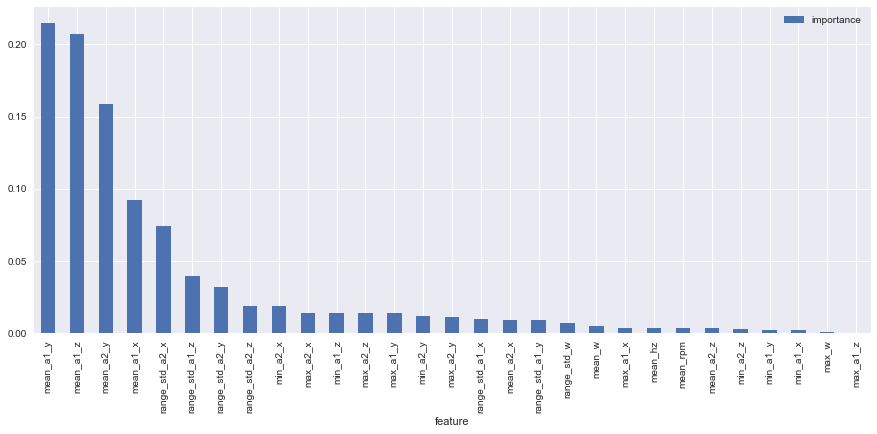

In [111]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(Model_rf.feature_importances_,3)})
importances1 = importances.sort_values('importance',ascending=False).set_index('feature')
importances1.plot(kind='bar',figsize=(15,6))

In [112]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = 6
""" for i, k in enumerate(neighbors): """
# Setup a k-NN Classifier with k neighbors: knn
knn = KNeighborsClassifier(n_neighbors = 6)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

#Compute accuracy on the training set
train_accuracy = knn.score(X_train, y_train)

#Compute accuracy on the testing set
test_accuracy = knn.score(X_test, y_test)

print("train accuracy : ",train_accuracy)
print("test accuracy : ",test_accuracy)

""" # Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show() """

train accuracy :  0.9101123595505618
test accuracy :  0.8260869565217391


" # Generate plot\nplt.title('k-NN: Varying Number of Neighbors')\nplt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')\nplt.plot(neighbors, train_accuracy, label = 'Training Accuracy')\nplt.legend()\nplt.xlabel('Number of Neighbors')\nplt.ylabel('Accuracy')\nplt.show() "